In [7]:
# for accessing tabular data
import pandas as pd
import numpy as np
import os
# adding classweight
from sklearn.utils import class_weight
# Evaluation Metric
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# for visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
# backend
import keras
from keras import backend as K
import tensorflow as tf
from keras.callbacks import Callback
from tensorflow.keras.models import Sequential, Model, load_model
# for transfer learning
from keras.applications import VGG16, VGG19
from keras.applications import DenseNet121
from keras.applications import ResNet50, ResNet152
from keras.applications import InceptionV3
from efficientnet.keras import EfficientNetB0, EfficientNetB3, EfficientNetB4
from keras.applications import Xception
# for model architecture
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D, MaxPooling2D, Activation, Flatten
# for Tensorboard visualization
from keras.callbacks import TensorBoard
# for Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

In [26]:
try:
    x_train = np.load("training.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
    x_validation = np.load("validation.npy",mmap_mode=None, allow_pickle=False, fix_imports=True)
    x_test = np.load("test.npy", mmap_mode = None,allow_pickle = False, fix_imports = True)
    print("Loaded Successfully...\n")
    print(x_train.shape)
    print(x_validation.shape)
    print(x_test.shape)
except:
    print("file not exists")

Loaded Successfully...

(3112, 512, 512, 3)
(550, 512, 512, 3)
(1928, 512, 512, 3)


In [27]:
type(x_train)

numpy.ndarray

In [32]:
train_labels = pd.read_csv('training.csv')
train_labels = train_labels['diagnosis']
validation_labels = pd.read_csv('validation.csv')
validation_labels = validation_labels['diagnosis']
print("Training:",train_labels.shape[0])
print("Validation:",validation_labels.shape[0])

Training: 3112
Validation: 550


In [ ]:
# x_train = x_train [:1500]
# x_test = x_test [:600]

In [ ]:
print(x_train.shape)
print(x_validation.shape)

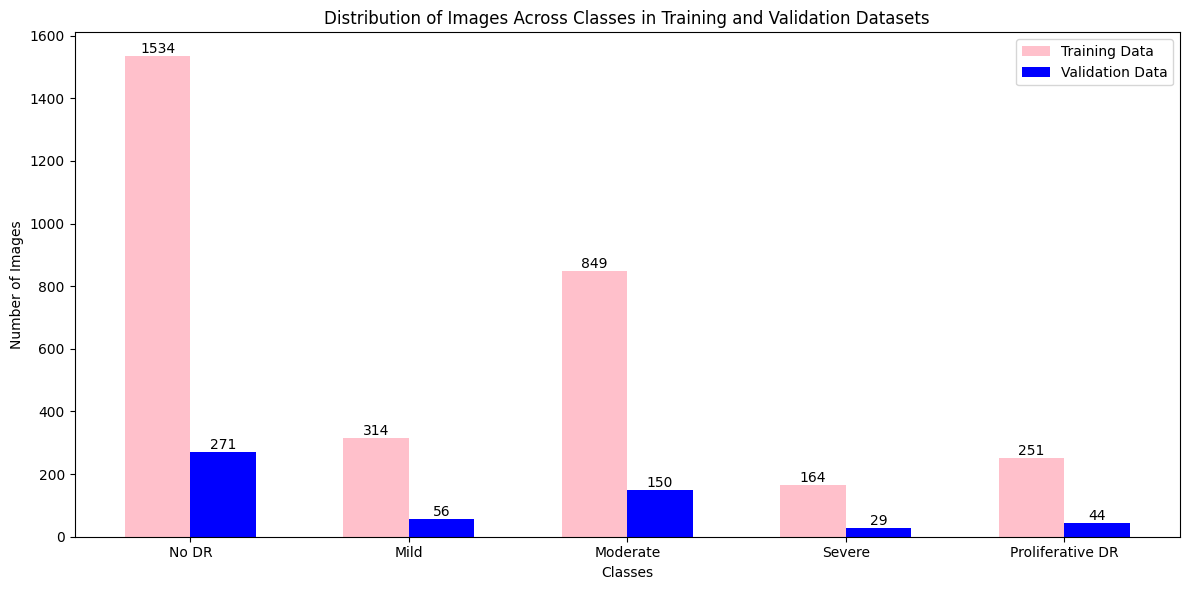

In [36]:
# Count the number of images per class for each dataset
train_counts = train_labels.value_counts()
validation_counts = validation_labels.value_counts()
# Update class names and align data with provided class names
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
train_data_counts_named = [train_counts.get(i, 0) for i in range(len(class_names))]
validation_data_counts_named = [validation_counts.get(i, 0) for i in range(len(class_names))]

# Plotting the data with updated class names and distinct colors
plt.figure(figsize=(12, 6))
index = np.arange(len(class_names))
bar_width = 0.3

plt.bar(index, train_data_counts_named, bar_width, color='pink', label='Training Data')
plt.bar(index + bar_width, validation_data_counts_named, bar_width, color='blue', label='Validation Data')

# Adding class counts on top of bars
for i in range(len(class_names)):
    plt.text(i, train_data_counts_named[i] + 10, str(train_data_counts_named[i]), ha='center')
    plt.text(i + bar_width, validation_data_counts_named[i] + 10, str(validation_data_counts_named[i]), ha='center')

# Setting labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes in Training and Validation Datasets')
plt.xticks(index + bar_width / 2, class_names)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()



In [50]:
def ordinal_regression(labels):
    """
    This function is used to create one_hot_encoding of the labels.
    E.x: category = 3 -> one-hot-encoding [1,1,1,1,0].
         category = 2 -> one-hot-encoding [1,1,1,0,0].
    """
    y_train = pd.get_dummies(labels).values
    y_train_multi = np.empty(y_train.shape, dtype=int)  # Change dtype to int
    y_train_multi[:, 4] = y_train[:, 4]

    for i in range(3, -1, -1):
        y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1]).astype(int)  # Convert boolean to int
    return y_train_multi
labels_train = ordinal_regression(train_labels)
labels_validation = ordinal_regression(validation_labels)
print(labels_train.shape)
print(labels_validation.shape)
print("Ex: Original Category: {}\n After one_hot_encoding: {}".format(train_labels.iloc[24],labels_train[24]))

(3112, 5)
(550, 5)
Ex: Original Category: 2
 After one_hot_encoding: [1 1 1 0 0]


In [12]:
labels_validation

array([[1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0],
       [1, 1, 0, 0, 0],
       ...,
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [13]:
labels_train

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0],
       ...,
       [1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1]])

In [14]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0, 1, 2, 3, 4]),y=train_labels)
print(class_weights)

[0.40573664 1.98216561 0.73309776 3.79512195 2.47968127]


In [15]:
from scipy.stats import f_oneway
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import VGG16, InceptionV3, Xception, MobileNetV2, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [90]:
def baseline_model():
    ''' This function is used for building a base line convolutional neural network architecture '''
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(2, 2), input_shape=[512,512,3], activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=128, activation = 'relu'))
    model.add(Dense(units=256, activation = 'relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(5, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])
    return model

In [91]:
from sklearn.utils import class_weight
import numpy as np

# Assuming your labels_train are integer labels for classes
# Compute class weights (this is an important step if your classes are imbalanced)

class_weights_dict = dict(enumerate(class_weights))
model = baseline_model()

# Now, fit the model
history = model.fit(
    x_train,
    labels_train,
    epochs=30,
    batch_size=32,
    verbose=1,
    class_weight=class_weights_dict,  # Use the computed class weights here
    validation_data=(x_validation, labels_validation)
)


Epoch 1/30
98/98 [==============================] - 92s 929ms/step - loss: 0.3557 - accuracy: 0.8448 - val_loss: 0.4544 - val_accuracy: 1.0000
Epoch 2/30
98/98 [==============================] - 88s 895ms/step - loss: 0.2031 - accuracy: 0.9978 - val_loss: 0.3937 - val_accuracy: 1.0000
Epoch 3/30
98/98 [==============================] - 83s 843ms/step - loss: 0.1792 - accuracy: 0.9990 - val_loss: 0.3827 - val_accuracy: 1.0000
Epoch 4/30
98/98 [==============================] - 86s 872ms/step - loss: 0.1677 - accuracy: 0.9997 - val_loss: 0.3704 - val_accuracy: 1.0000
Epoch 5/30
98/98 [==============================] - 84s 858ms/step - loss: 0.1598 - accuracy: 1.0000 - val_loss: 0.3611 - val_accuracy: 1.0000
Epoch 6/30
98/98 [==============================] - 92s 941ms/step - loss: 0.1538 - accuracy: 1.0000 - val_loss: 0.3445 - val_accuracy: 1.0000
Epoch 7/30
98/98 [==============================] - 86s 874ms/step - loss: 0.1474 - accuracy: 1.0000 - val_loss: 0.3247 - val_accuracy: 1.0000

In [87]:
x_train.shape

(3112, 512, 512, 3)

In [74]:
# model.save('./baseline_model.h5')

/Users/krishnamridha/anaconda3/envs/Retina/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [75]:
model = load_model('./baseline_model.h5')

In [16]:
from tensorflow.keras.layers import Layer, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Multiply, Reshape
from tensorflow.keras.models import Sequential
import tensorflow as tf

class SqueezeExciteBlock(Layer):
    def __init__(self, ratio=16, **kwargs):
        super(SqueezeExciteBlock, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.se_shape = (1, 1, self.filters)

        self.dense_1 = Dense(self.filters // self.ratio, activation='relu', use_bias=False)
        self.dense_2 = Dense(self.filters, activation='sigmoid', use_bias=False)

    def call(self, inputs):
        se = GlobalAveragePooling2D()(inputs)
        se = Reshape(self.se_shape)(se)
        se = self.dense_1(se)
        se = self.dense_2(se)
        return Multiply()([inputs, se])

    def get_config(self):
        config = super(SqueezeExciteBlock, self).get_config()
        config.update({"ratio": self.ratio})
        return config

def baseline_model_with_attention():
    ''' This function is used for building a baseline convolutional neural network architecture with self-attention '''
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(filters=16, kernel_size=(2, 2), input_shape=[512,512,3], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), activation='relu'))
    
    # Self-attention layer
    model.add(SqueezeExciteBlock())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(GlobalAveragePooling2D())

    # Fully connected layers
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=512, activation='relu'))

    # Output layer
    model.add(Dense(5, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])

    return model


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Assuming your labels_train are integer labels for classes
# Compute class weights (this is an important step if your classes are imbalanced)

class_weights_dict = dict(enumerate(class_weights))
model = baseline_model_with_attention()

# Now, fit the model
history = model.fit(
    x_train,
    labels_train,
    epochs=30,
    batch_size=32,
    verbose=1,
    class_weight=class_weights_dict,  # Use the computed class weights here
    validation_data=(x_validation, labels_validation)
)


In [ ]:

# df = pd.DataFrame({
#     'accuracy': history.history['accuracy'],
#     'val_accuracy': history.history['val_accuracy'],
#     'loss': history.history['loss'],
#     'val_loss': history.history['val_loss']
# })

# # Saving the DataFrame to a CSV file
# csv_file_path = './attention_training_history.csv'  # You can change the file path as needed
# df.to_csv(csv_file_path, index=False)
# model.save('./attention_model.h5')




In [ ]:
# Assuming 'history' is the return value from the model.fit call
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Get number of epochs

# Plot training and validation accuracy per epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Base Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for Base Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
from tensorflow.keras.models import load_model

# Define the custom object. The key is the name used in the model.
custom_objects = {'SqueezeExciteBlock': SqueezeExciteBlock}

# Load the model with the custom object
model = load_model('attention_model.h5', custom_objects=custom_objects)



In [22]:
class PerformanceMetric:
    def __init__(self,actual_labels,predicted_labels):
        ''' Initialization of variables '''
        self.actual_labels = actual_labels
        self.predicted_labels = predicted_labels
    def single_value_conversion(self):
        ''' This function is used for Converting model predicted values into single values
           Ex: model_predicted_value: [0,1,0,0,0] and it converts as 1'''
        predicted_labels = self.predicted_labels > 0.5
        prediction_ordinal = np.empty(predicted_labels.shape, dtype = int)
        prediction_ordinal[:,4] = predicted_labels[:,4]
        for i in range(3, -1, -1): prediction_ordinal[:, i] = np.logical_or(predicted_labels[:,i], prediction_ordinal[:,i+1])
        self.predicted_labels = prediction_ordinal.sum(axis = 1)-1
        self.actual_labels = self.actual_labels.sum(axis = 1)-1
    def value(self):
        return (self.actual_labels, self.predicted_labels)
        
    def confusionMatrix(self):
        ''' This function is used for calculating confusion matrix between model predicted values and true values using sklearn implementation.'''
        confusion_matrix_ = confusion_matrix(self.actual_labels, self.predicted_labels)
        return confusion_matrix_
    def precision(self, matrix):
        ''' This function is used for calculating precision matrix between predicted values and true values using confusion matrix'''
        precision_matrix =(((matrix.T)/(matrix.sum(axis=1))).T)
        return precision_matrix
        
    def recall(self, matrix):
        ''' this function is used for calculating recall matrix between predicted values and true values using confusion matrix'''
        recall_matrix =(matrix/matrix.sum(axis=0))
        return recall_matrix
    
    def subplot_(self, matrix, i, title):
        ''' This function is used for subplots'''
        plt.subplot(1, 3, i)
        labels = [0, 1, 2, 3, 4]

        # Choose a different color palette for each type of matrix
        if title == 'Confusion Matrix':
            cmap = sns.color_palette("coolwarm", as_cmap=True)
        elif title == 'Precision':
            cmap = sns.color_palette("YlOrRd", as_cmap=True)
        else:  # Recall
            cmap = sns.color_palette("Greens", as_cmap=True)

        sns.heatmap(matrix, annot=True, cmap=cmap, linewidths=0.8, cbar=False,  xticklabels=labels, yticklabels=labels)
        plt.title(title)
        plt.xlabel('Predicted Class Labels')
        plt.ylabel('Actual Class Labels')

    def confusion(self):
        confusion_matrix = self.confusionMatrix()
        return confusion_matrix

    def plotting(self):
        """
        This function is used for calculating the number of misclassified points, confusion, recall, and precision matrices 
        and plotting them using subplots.
        """
        self.single_value_conversion()
        confusion_matrix = self.confusionMatrix()
        print(confusion_matrix)
        precision_matrix = self.precision(confusion_matrix)
        recall_matrix = self.recall(confusion_matrix)
        plt.figure(figsize=(20, 5))
        self.subplot_(confusion_matrix, 1, 'Confusion Matrix')
        self.subplot_(precision_matrix, 2, 'Precision')
        self.subplot_(recall_matrix, 3, 'Recall')
        plt.show()

18/18 [==============================] - 4s 185ms/step
[[254   3  14   0   0]
 [  6   0  50   0   0]
 [  4   3 143   0   0]
 [  0   1  27   1   0]
 [  0   0  43   1   0]]


/var/folders/zf/wtvvvvdj7lg8xqsqrft6_z100000gn/T/ipykernel_30820/2026186541.py:29: RuntimeWarning: invalid value encountered in divide
  recall_matrix =(matrix/matrix.sum(axis=0))


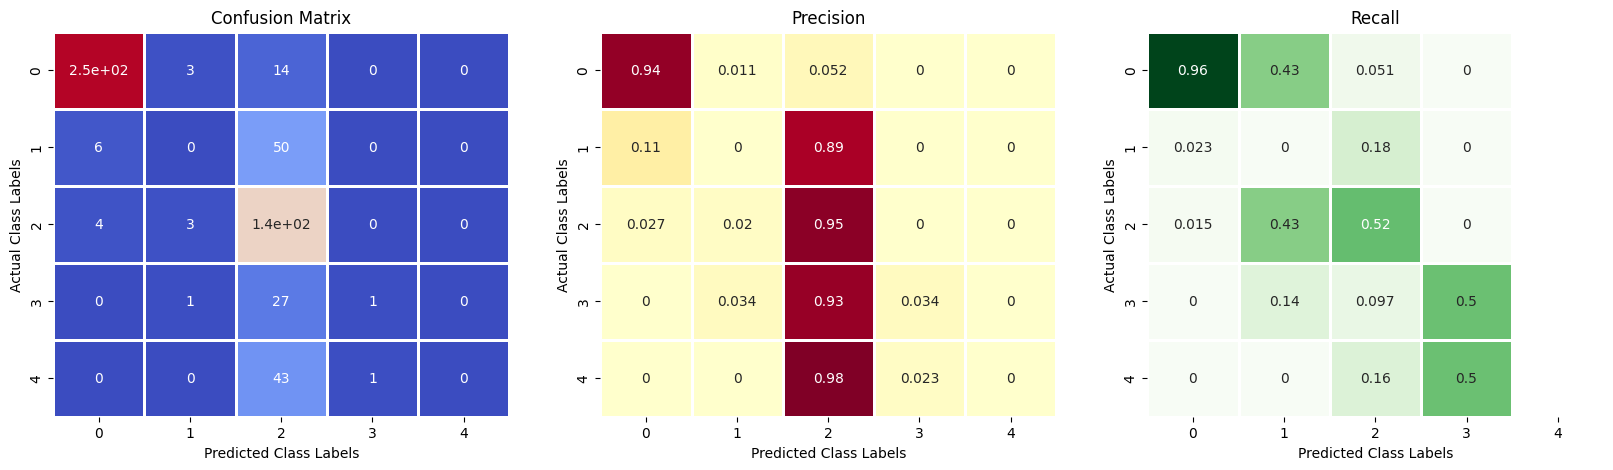

In [23]:
result = model.evaluate(x_validation, labels_validation)
y_pred = model.predict(x_validation)
metrixc = PerformanceMetric(labels_validation, y_pred)
metrixc.plotting()

In [63]:
actual, predicted = metrixc.value()


In [92]:
print(actual)

[1 2 1 0 0 0 2 3 0 3 1 2 4 0 1 2 2 2 0 2 2 4 0 0 0 4 0 0 0 0 0 0 2 2 0 0 2
 0 4 0 1 2 0 0 2 0 0 3 1 0 0 0 1 0 2 0 0 0 0 2 0 0 2 2 4 0 0 2 4 0 0 0 0 2
 4 3 2 4 2 0 0 2 0 4 0 0 0 0 2 2 0 1 0 4 2 2 3 0 0 0 0 1 0 1 2 0 0 0 0 4 4
 2 0 0 0 0 0 0 0 4 2 4 0 0 0 0 4 2 4 2 3 0 0 0 0 0 0 2 0 1 3 0 1 0 0 2 0 2
 1 0 0 0 2 0 4 2 1 2 2 2 3 2 0 0 3 2 0 0 4 3 0 0 2 2 4 0 0 2 0 4 2 0 1 2 4
 2 0 0 0 1 2 0 2 2 0 0 0 0 0 2 0 2 1 0 0 0 2 2 0 0 0 2 0 1 4 3 1 2 0 0 0 0
 0 0 2 0 2 0 2 0 0 3 0 0 0 0 2 4 0 0 0 2 2 0 4 2 1 1 2 2 1 0 2 3 0 0 3 2 2
 0 2 0 2 3 1 0 0 0 0 3 1 0 0 2 0 2 3 0 0 1 2 0 0 3 0 0 0 0 0 1 1 2 4 2 0 0
 0 0 0 4 0 0 4 0 2 2 2 0 2 2 0 1 3 2 2 4 0 3 0 2 0 4 3 0 2 4 0 0 2 3 0 2 1
 4 1 0 1 0 1 2 0 0 0 0 2 0 0 0 0 2 2 0 2 1 2 2 0 0 3 0 4 1 4 1 0 1 2 0 2 0
 0 4 2 2 0 1 2 0 2 0 0 2 0 0 4 2 0 0 0 0 0 1 0 2 1 0 2 2 0 2 0 2 0 4 2 0 2
 3 2 1 0 0 2 0 0 0 0 3 1 0 2 0 0 2 2 0 2 0 1 2 0 0 0 0 2 0 0 0 0 0 0 4 2 0
 0 0 0 0 0 0 1 0 0 0 4 3 2 4 2 2 0 0 0 2 2 0 2 0 1 2 0 2 2 0 2 2 2 0 2 3 2
 2 0 0 0 0 0 2 0 0 0 2 1 

In [93]:
print(predicted)

[2 2 2 0 1 0 2 2 0 2 2 2 3 0 2 2 2 2 0 2 2 2 0 0 0 2 0 0 0 0 0 0 2 2 0 0 2
 0 2 0 2 2 0 0 1 0 0 2 2 0 0 0 2 0 2 0 0 0 0 2 0 2 2 2 2 0 0 2 2 0 0 0 0 2
 2 2 2 2 2 0 2 2 0 2 0 0 0 0 2 2 0 2 2 2 2 2 2 0 0 0 0 2 0 2 2 0 0 0 0 2 2
 2 0 0 0 0 0 0 0 2 2 2 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 2 0 2 2 0 2 0 0 2 0 2
 2 0 0 0 2 0 2 2 2 2 2 2 1 2 0 0 2 2 0 0 2 2 0 0 1 2 2 0 0 2 0 2 2 0 2 2 2
 2 0 0 0 0 1 0 2 2 0 0 0 0 0 2 0 2 2 0 0 0 2 2 0 0 0 2 0 2 2 2 2 2 0 0 0 0
 0 0 2 0 0 0 2 0 0 2 0 0 0 0 2 2 0 0 0 2 0 0 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2
 0 2 0 2 2 0 0 0 0 0 2 2 0 0 2 0 2 2 2 0 2 2 0 0 2 0 0 0 0 1 0 2 2 2 2 0 0
 0 0 0 2 0 0 2 0 2 2 2 0 2 2 0 2 2 2 2 2 0 2 0 2 0 2 2 0 2 2 0 0 2 2 0 2 2
 2 2 0 0 0 2 2 2 0 0 0 2 0 0 0 0 2 2 0 2 2 2 2 0 2 2 0 2 2 2 2 0 0 2 0 2 0
 0 2 2 2 0 2 2 0 2 0 2 0 0 0 2 2 0 0 0 0 0 2 0 2 2 2 2 2 0 2 2 2 0 2 2 0 2
 2 2 2 0 0 2 0 0 0 0 2 2 0 2 2 0 2 2 2 2 0 2 2 0 0 0 0 2 0 0 0 0 0 0 2 2 0
 0 0 2 0 0 0 2 0 1 0 2 2 2 2 2 2 0 0 0 2 0 0 2 0 2 2 0 2 2 0 2 2 2 0 2 2 2
 2 0 0 0 0 0 2 2 0 0 2 2 

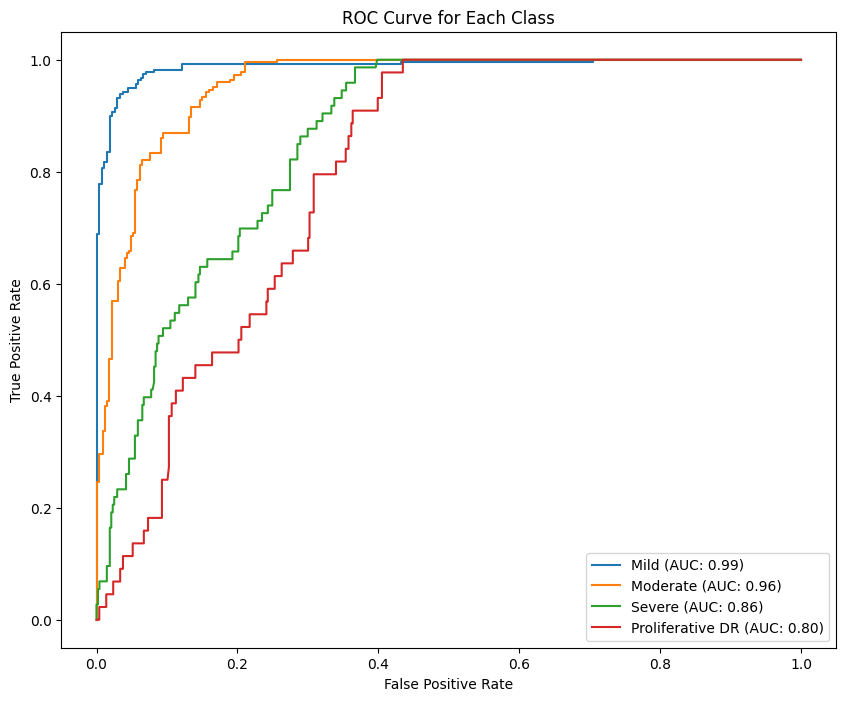

AUC Scores by Class: {'Mild': 0.988876985544049, 'Moderate': 0.9572276847547345, 'Severe': 0.859510065764912, 'Proliferative DR': 0.7978126122888969}


In [66]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Provided actual labels and predicted probabilities
actual_labels = labels_validation  # Assuming this is a numpy array
predicted_probabilities = y_pred  # Assuming this is a numpy array

# Class names
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# Initialize an empty dictionary for AUC scores
auc_scores = {}

# Iterate over each class to calculate AUC-ROC where possible
for i, class_name in enumerate(class_names):
    if len(np.unique(actual_labels[:, i])) > 1:
        auc_scores[class_name] = roc_auc_score(actual_labels[:, i], predicted_probabilities[:, i])

# Plotting ROC Curves for classes where AUC-ROC was calculated
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    if class_name in auc_scores:
        fpr, tpr, _ = roc_curve(actual_labels[:, i], predicted_probabilities[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUC: {auc_scores[class_name]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='best')
plt.show()

# Output the AUC scores
print("AUC Scores by Class:", auc_scores)


In [67]:
import numpy as np
from sklearn.metrics import roc_auc_score

auc_scores = []
for i in range(predicted_probabilities.shape[1]):
    if len(np.unique(actual_labels[:, i])) > 1:  # Check for both positive and negative instances
        auc = roc_auc_score(actual_labels[:, i], predicted_probabilities[:, i])
        auc_scores.append(auc)

# Calculate macro-average AUC-ROC
macro_avg_auc_roc = np.mean(auc_scores) if auc_scores else None

print("Macro-average AUC-ROC:", macro_avg_auc_roc)


Macro-average AUC-ROC: 0.9008568370881481


In [68]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 511, 511, 16)      208       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 255, 255, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 254, 254, 32)      2080      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 126, 126, 64)      8256      
                                                                 
 squeeze_excite_block (Sque  (None, 126, 126, 64)     